In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Import Data

In [2]:
ticker_resample_df = pd.read_csv('../data/clean/ticker_5s.csv')

In [3]:
ticker_resample_df.head()

,ticker,ticker_desc,ticker_desc_short,date,datetime,price,log_price,return,return_5s,return_60s,rv_sub,two_scale_realized_var,sigma_2_hat,two_scale_realized_var_biased,two_scale_realized_vol,two_scale_realized_vol_100
0,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:00,111.15,4.710881,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:05,111.16,4.710971,0.00009,0.00009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:10,111.16,4.710971,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:15,111.15,4.710881,-0.00009,-0.00009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:20,111.15,4.710881,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prep data

In [4]:
# Fix datetime column and sort data
ticker_resample_df['datetime'] = pd.to_datetime(ticker_resample_df['datetime'])
ticker_resample_df = ticker_resample_df.sort_values(by = ['ticker', 'date', 'datetime'])

In [5]:
# Set realized volatility 
ticker_resample_df['realized_vol'] = ticker_resample_df['two_scale_realized_vol_100']

# Tables

## Generate Statistics

In [6]:
def test_changes(ticker_day_df, test_var, delta_min = 30):
    # Tests the difference in realized volatility delta_min minutes before and after the FOMC announcements
    # ticker_day_df is a dataframe corresponding to a specific ticker and specific day
    fomcrelease_datetime = pd.to_datetime(ticker_day_df["date"].iloc[0] + " 14:00:00")
    ticker_day_df["datetime_minus_fomcrelease"] = pd.to_datetime(ticker_day_df["datetime"]).apply(
        lambda x: x - fomcrelease_datetime
    )

    ticker_day_df["is_delta_min_before_fomcrelease"] = (
        (-ticker_day_df["datetime_minus_fomcrelease"] < pd.Timedelta(f"{delta_min} minutes"))
        & (ticker_day_df["datetime_minus_fomcrelease"] <= pd.Timedelta("0 seconds"))
    ).astype(int)

    ticker_day_df["is_delta_min_after_fomcrelease"] = (
        (ticker_day_df["datetime_minus_fomcrelease"] < pd.Timedelta(f"{delta_min} minutes"))
        & (ticker_day_df["datetime_minus_fomcrelease"] > pd.Timedelta("0 seconds"))
    ).astype(int)

    # Average realized volatility before and after
    avg_rv_before = ticker_day_df.query("is_delta_min_before_fomcrelease == 1")[test_var].mean()
    avg_rv_after = ticker_day_df.query("is_delta_min_after_fomcrelease == 1")[test_var].mean()

    # T-test change (means)
    ttest_t, ttest_p = sp.stats.ttest_ind(
        ticker_day_df.query("is_delta_min_after_fomcrelease == 1")[test_var],
        ticker_day_df.query("is_delta_min_before_fomcrelease == 1")[test_var],
        equal_var=False,
    )

    # U-test change (medians)
    utest_u, utest_p = sp.stats.mannwhitneyu(
        ticker_day_df.query("is_delta_min_before_fomcrelease == 1")[test_var],
        ticker_day_df.query("is_delta_min_after_fomcrelease == 1")[test_var],
        alternative="two-sided",
    )

    return dict(
        zip(
            ("average_before", "average_after", "ttest_t", "ttest_p", "utest_u", "utest_pvalue"),
            (avg_rv_before, avg_rv_after, ttest_t, ttest_p, utest_u, utest_p),
        )
    )

In [7]:
tqdm.pandas()
rv_changes_results_df = (
    ticker_resample_df.groupby(["date", "ticker", "ticker_desc", "ticker_desc_short"])
    .progress_apply(lambda df: test_changes(df, test_var = 'realized_vol', delta_min = 30))
    .apply(pd.Series)
    .reset_index()
)

rv_changes_results_df['difference'] = rv_changes_results_df['average_after'] - rv_changes_results_df['average_before']
rv_changes_results_df = rv_changes_results_df.sort_values(['date', 'ticker'])

In [8]:
# Table of results for RV changes
print(rv_changes_results_df.query('date == "2020-08-19"').sort_values(by = 'ticker_desc_short').drop(columns = ['date', 'ticker_desc_short', 'utest_u', 'utest_pvalue'], axis = 1)[['ticker', 'ticker_desc', 'average_before', 'average_after', 'difference', 'ttest_t', 'ttest_p']].reset_index(drop = True).to_latex(index = False))

\begin{tabular}{llrrrrr}
\toprule
ticker &                           ticker\_desc &  average\_before &  average\_after &  difference &    ttest\_t &        ttest\_p \\
\midrule
   SHY &    iShares 1-3 Year Treasury Bond ETF &        0.084679 &       0.067734 &   -0.016945 &  -6.275127 &   6.124280e-10 \\
   TLH &  iShares 10-20 Year Treasury Bond ETF &        0.291005 &       0.971577 &    0.680571 &  32.171930 &  7.039643e-110 \\
   TLT &    iShares 20+ Year Treasury Bond ETF &        0.336256 &       1.295328 &    0.959072 &  38.139927 &  3.667126e-130 \\
   IEI &    iShares 3-7 Year Treasury Bond ETF &        0.055371 &       0.140424 &    0.085053 &  32.584644 &  9.770234e-133 \\
   IEF &   iShares 7-10 Year Treasury Bond ETF &        0.117278 &       0.333805 &    0.216526 &  45.417918 &  9.043730e-175 \\
\bottomrule
\end{tabular}



In [14]:
rv_changes_results_df.sample(5)

,date,ticker,ticker_desc,ticker_desc_short,average_before,average_after,ttest_t,ttest_p,utest_u,utest_pvalue,difference
23,2020-07-01,TLH,iShares 10-20 Year Treasury Bond ETF,10-20 Year,0.176660,0.269208,6.382721,3.160293e-10,32436.0,6.581568e-31,0.092548
29,2020-08-19,TLT,iShares 20+ Year Treasury Bond ETF,20+ Year,0.336256,1.295328,38.139927,3.667126e-130,1922.0,2.944942e-112,0.959072
24,2020-07-01,TLT,iShares 20+ Year Treasury Bond ETF,20+ Year,0.348350,0.444871,9.766711,3.979658e-21,39219.0,7.406405e-20,0.096521
3,2020-01-03,TLH,iShares 10-20 Year Treasury Bond ETF,10-20 Year,0.364032,0.321777,-2.567527,1.045172e-02,70726.5,2.829970e-02,-0.042255
25,2020-08-19,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,0.117278,0.333805,45.417918,9.043730e-175,284.0,4.274025e-118,0.216526


In [9]:
tqdm.pandas()
ticker_resample_df['log_price'] = np.log(ticker_resample_df['price'])
lp_changes_results_df = (
    ticker_resample_df.groupby(["date", "ticker", "ticker_desc", "ticker_desc_short"])
    .progress_apply(lambda df: test_changes(df, test_var = 'log_price', delta_min = 30))
    .apply(pd.Series)
    .reset_index()
)

lp_changes_results_df['difference'] = lp_changes_results_df['average_after'] - lp_changes_results_df['average_before']
lp_changes_results_df = lp_changes_results_df.sort_values(['date', 'ticker'])

## Plot of table results

In [58]:
def sig_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

### RV changes

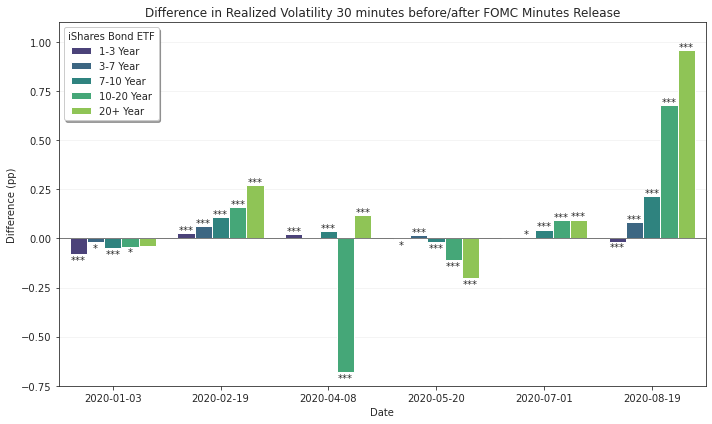

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    y="difference",
    x="date",
    hue="ticker_desc_short",
    hue_order=["1-3 Year", "3-7 Year", "7-10 Year", "10-20 Year", "20+ Year"],
    palette=sns.color_palette("viridis", 5),
    data=rv_changes_results_df,
    ax=ax,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)

# Add significance stars
plt.ylim(-1, 1)
for rectangle in ax.patches:
    x, y = rectangle.get_xy()
    height = rectangle.get_height()
    width = rectangle.get_width()
    x_loc = x + width / 2
    y_loc = height if height > 0 else height - 0.045
    pvalue = rv_changes_results_df["ttest_p"].loc[
        (np.abs(rv_changes_results_df["difference"] - height)).idxmin()
    ]
    plt.text(x_loc, y_loc, sig_stars(pvalue), ha="center")

# Fix legend
plt.legend(
    loc="upper left",
    title="iShares Bond ETF",
    fontsize=10,
    shadow=True,
)

plt.ylim(-0.75, 1.1)
plt.title('Difference in Realized Volatility 30 minutes before/after FOMC Minutes Release')
plt.ylabel('Difference (pp)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../exhibits/ishares_rv_differences.pdf')

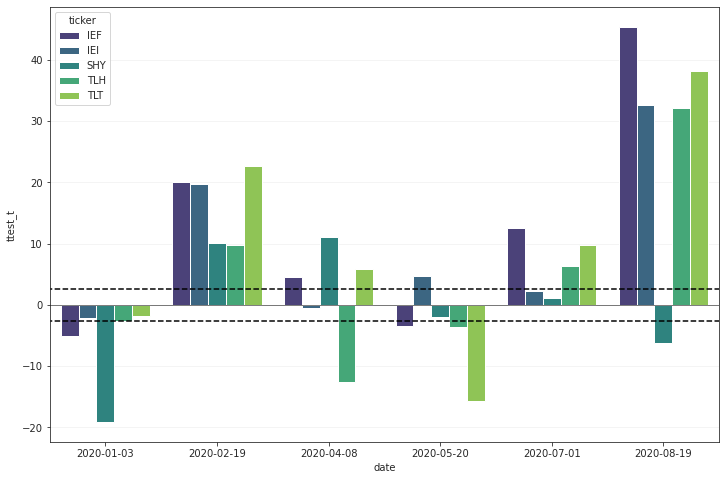

In [60]:
# T-stats
plt.figure(figsize=(12, 8))
sns.barplot(
    y="ttest_t",
    x="date",
    hue="ticker",
    palette=sns.color_palette("viridis", 5),
    data=rv_changes_results_df,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)
plt.axhline(sp.stats.norm.ppf(0.005), -1, 1, color="k", ls="--")
plt.axhline(-sp.stats.norm.ppf(0.005), -1, 1, color="k", ls="--")

### Log(Price) Changes

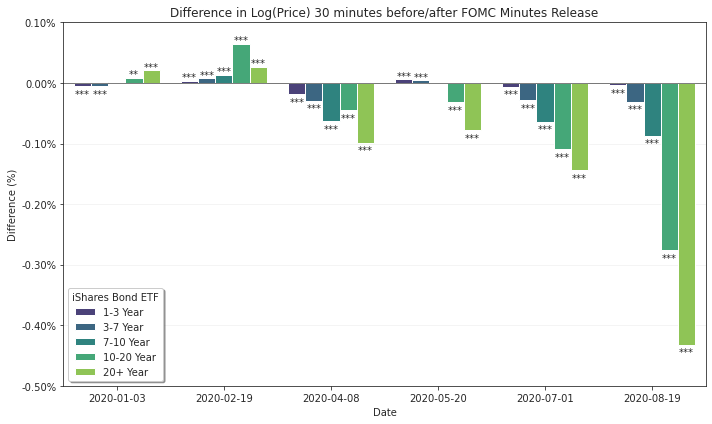

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    y="difference",
    x="date",
    hue="ticker_desc_short",
    hue_order=["1-3 Year", "3-7 Year", "7-10 Year", "10-20 Year", "20+ Year"],
    palette=sns.color_palette("viridis", 5),
    data=lp_changes_results_df,
    ax=ax,
)
plt.axhline(0, -1, 1, color="k", lw=0.5)

# Add significance stars
plt.ylim(-1, 1)
for rectangle in ax.patches:
    x, y = rectangle.get_xy()
    height = rectangle.get_height()
    width = rectangle.get_width()
    x_loc = x + width / 2
    y_loc = height if height > 0 else height - 0.00018
    pvalue = lp_changes_results_df["ttest_p"].loc[
        (np.abs(lp_changes_results_df["difference"] - height)).idxmin()
    ]
    plt.text(x_loc, y_loc, sig_stars(pvalue), ha="center")

# Fix legend
plt.legend(
    loc="lower left",
    title="iShares Bond ETF",
    fontsize=10,
    shadow=True,
)

plt.ylim(-0.005, 0.001)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1))
plt.title('Difference in Log(Price) 30 minutes before/after FOMC Minutes Release')
plt.ylabel('Difference (%)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../exhibits/ishares_logprice_differences.pdf')